In [3]:
# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os

INIT_LR = 1e-4
EPOCHS = 10
BS = 12

DIRECTORY = r"C:\MY\Miniconda_py\Volume Gesture\imginput"
CATEGORIES = ["up", "down"]

# grab the list of images in our dataset directory, then initialize
# the list of data (i.e., images) and class images
print("[INFO] loading images...")


[INFO] loading images...


In [4]:

data = []
labels = []

for category in CATEGORIES:
    path = os.path.join(DIRECTORY, category)
    for img in os.listdir(path):
    	img_path = os.path.join(path, img)
    	image = load_img(img_path, target_size=(224, 224))
    	image = img_to_array(image)
    	image = preprocess_input(image)

    	data.append(image)
    	labels.append(category)

# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

data = np.array(data, dtype="float32")
labels = np.array(labels)

In [5]:
(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.20, stratify=labels, random_state=42)

# construct the training image generator for data augmentation
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")


In [6]:
baseModel = MobileNetV2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process



In [7]:
for layer in baseModel.layers:
	layer.trainable = False

In [8]:
# compile our model
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])

# train the head of the network
print("[INFO] training head...")
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)

    

[INFO] compiling model...
[INFO] training head...


C:\Users\Admin\miniconda3\envs\sr28\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/10
24/24 [==============================] - 16s 237ms/step - loss: 0.7732 - accuracy: 0.5923 - val_loss: 0.6161 - val_accuracy: 0.7067
Epoch 2/10
24/24 [==============================] - 2s 100ms/step - loss: 0.6058 - accuracy: 0.7317 - val_loss: 0.4956 - val_accuracy: 0.8133
Epoch 3/10
24/24 [==============================] - 2s 92ms/step - loss: 0.5071 - accuracy: 0.8014 - val_loss: 0.4107 - val_accuracy: 0.8533
Epoch 4/10
24/24 [==============================] - 2s 92ms/step - loss: 0.4483 - accuracy: 0.8328 - val_loss: 0.3513 - val_accuracy: 0.8800
Epoch 5/10
24/24 [==============================] - 2s 92ms/step - loss: 0.3606 - accuracy: 0.9094 - val_loss: 0.3054 - val_accuracy: 0.8933
Epoch 6/10
24/24 [==============================] - 2s 91ms/step - loss: 0.3589 - accuracy: 0.8676 - val_loss: 0.2741 - val_accuracy: 0.9200
Epoch 7/10
24/24 [==============================] - 2s 92ms/step - loss: 0.3022 - accuracy: 0.9094 - val_loss: 0.2534 - val_accuracy: 0.9200
Epoch 8/10

In [9]:

# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=lb.classes_))

[INFO] evaluating network...
7/7 [==============================] - 1s 23ms/step
              precision    recall  f1-score   support

        down       0.95      1.00      0.98        40
          up       1.00      0.94      0.97        35

    accuracy                           0.97        75
   macro avg       0.98      0.97      0.97        75
weighted avg       0.97      0.97      0.97        75



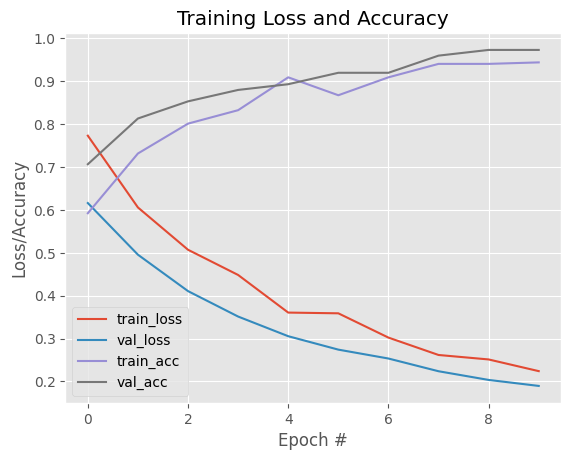

In [10]:

# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")

In [11]:
import keyboard
from ctypes import cast, POINTER
from comtypes import CLSCTX_ALL
from pycaw.pycaw import AudioUtilities, IAudioEndpointVolume

def press_key_based_on_output(output):
    devices = AudioUtilities.GetSpeakers()
    interface = devices.Activate(IAudioEndpointVolume._iid_, CLSCTX_ALL, None)
    volume = cast(interface, POINTER(IAudioEndpointVolume))

    if output == 0:
        curr = volume.GetMasterVolumeLevel()
        print(curr)
        volume.SetMasterVolumeLevel(curr - 1.0, None)

    else : 
        curr = volume.GetMasterVolumeLevel()
        print(curr)
        volume.VolumeStepUp(None)
        print(volume.GetMasterVolumeLevel())



In [13]:
import cv2
import numpy as np

def detect_sign(img, model):
    # Preprocess the image: resize and normalize pixel values
    img = cv2.resize(img, (224, 224))  # Resize the image to the target size (224x224)
    img = img.astype("float32") / 255.0  # Normalize pixel values to range [0, 1]
    img = np.expand_dims(img, axis=0)  # Add batch dimension

    # Predict face mask
    y_pred_prob = model.predict(img)
    y_pred_class = np.argmax(y_pred_prob, axis=1)

    
    # Example usage:
    output = y_pred_class  # or 1
    press_key_based_on_output(output)
    return y_pred_class

# Load the image
img1 = cv2.imread(r"C:\MY\Miniconda_py\Volume Gesture\images\up\Screenshot 2024-05-30 135006 - Copy.png")

# Assuming 'model' is your trained model
prediction = detect_sign(img1, model)
print("Predicted class:", prediction)


1/1 [==============================] - 0s 80ms/step
-18.236774444580078
-17.261470794677734
Predicted class: [1]


In [17]:
import cv2
import numpy as np
import time

# Define your face mask detection function

# Open the video capture
cap = cv2.VideoCapture(0)

# Check if the video capture is opened successfully
if not cap.isOpened():
    print("Error: Could not open video capture.")
else:
    last_capture_time = time.time()
    while True:
        ret, frame = cap.read()
        if not ret:
            break

        # Check if two seconds have passed since the last capture
        if time.time() - last_capture_time >= 2:
            # Resize the frame
            resized_frame = cv2.resize(frame, (224, 224))

            # Perform face mask detection
            y_pred = detect_sign(resized_frame, model)

            print(y_pred)

            last_capture_time = time.time()  # Update the last capture time

        # Display the frame using cv2.imshow
        cv2.imshow("window", frame)

        # Handle key press to exit
        if cv2.waitKey(1) & 0xFF == ord('x'):
            break

    # Release the video capture and close windows
    cap.release()
    cv2.destroyAllWindows()


1/1 [==============================] - 0s 41ms/step
-10.508596420288086
-9.914539337158203
[1]
1/1 [==============================] - 0s 41ms/step
-9.914539337158203
-9.342827796936035
[1]
1/1 [==============================] - 0s 32ms/step
-9.342827796936035
-8.791844367980957
[1]
1/1 [==============================] - 0s 36ms/step
-8.791844367980957
[0]
1/1 [==============================] - 0s 41ms/step
-9.791844367980957
[0]
1/1 [==============================] - 0s 33ms/step
-10.791844367980957
-9.914539337158203
[1]
1/1 [==============================] - 0s 32ms/step
-9.914539337158203
-9.342827796936035
[1]
1/1 [==============================] - 0s 41ms/step
-9.342827796936035
-8.791844367980957
[1]
1/1 [==============================] - 0s 41ms/step
-8.791844367980957
-8.260135650634766
[1]
1/1 [==============================] - 0s 39ms/step
-8.260135650634766
-7.746397495269775
[1]
1/1 [==============================] - 0s 40ms/step
-7.746397495269775
[0]
1/1 [================

KeyboardInterrupt: 